**1. Some income data, lognormal distribution, and GMM**

In [128]:
#a
import pandas as pd
import numpy as np
income = pd.read_csv("incomes.txt",names=["income"])

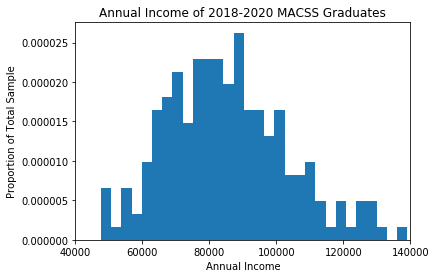

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline
num_bins = 30
count,bins,ignored = plt.hist(income["income"], num_bins,normed=True)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.xlim([40000, 140000])
plt.show()

In [130]:
#summary=income.describe()
#d_mean=summary.loc["mean","income"]
#d_std=summary.loc["std","income"]
#d_mvec=np.array([d_mean,d_std])

In [131]:
import scipy.stats as sts

def lognorm(x,mu,sig):
    return 1/(x*sig * np.sqrt(2 * np.pi))*np.e**(-(np.log(x) - mu)**2 / (2 * sig**2))

def trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub):

    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.lognorm.cdf(cut_lb, sigma, scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu))
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.lognorm.cdf(cut_ub, sigma,scale=np.exp(mu)) -
                       sts.lognorm.cdf(cut_lb, sigma,scale=np.exp(mu)))
            
    pdf_vals = ((1/(x*sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (np.log(x) - mu)**2 / (2 * sigma**2))) /
                prob_notcut)
    
    return pdf_vals 

In [132]:
def data_moments(x):
    mean_data = x.mean()
    std_data = x.std()
    
    return mean_data, std_data

import scipy.integrate as intgr

def model_moments(mu, sigma, cut_lb, cut_ub):
    
    xfx = lambda x: x * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model)**2) * trunc_lognorm_pdf(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    std_model = np.sqrt(var_model)
    
    return mean_model, std_model

def err_vec(x, mu, sigma, cut_lb, cut_ub, simple):
  
    mean_data, std_data = data_moments(x)
    mom_data = np.array([[mean_data], [std_data]])
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    mom_model = np.array([[mean_model], [std_model]])
    
    if simple:
        err_vec = mom_model - mom_data
    else:
        err_vec = (mom_model - mom_data) / mom_data
    
    return err_vec

def crit(params, *args):

    mu, sigma = params
    x, cut_lb, cut_ub, W = args
    err = err_vec(x, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val



In [133]:
import scipy.optimize as opt
mu_init=11
sigma_init=0.5
para_init=(mu_init,sigma_init)
gmm_args=(income["income"],0.0,150000.0,np.eye(2))
results = opt.minimize(crit,para_init,args=(gmm_args),method='L-BFGS-B',tol=1e-14,bounds=((None, None), (1e-10, None)))

In [134]:
mu_GMM,sig_GMM=results.x
print("mu_GMM:",mu_GMM,"sigma_GMM:",sig_GMM)

mu_GMM: 11.33353348254704 sigma_GMM: 0.21386191435240418


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


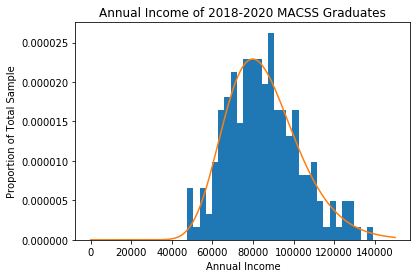

In [135]:
num_bins = 30
count,bins,ignored = plt.hist(income["income"], num_bins,normed=True)
pts=np.linspace(0,150000,100000)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM, sig_GMM,0,150000))
plt.show()

In [136]:
para_gmm=mu_GMM,sig_GMM
crit_val=crit(para_gmm,income["income"],0,150000,np.eye(2))
print("the value of my GMM criterion function at the estimated parameter values is:",crit_val)

the value of my GMM criterion function at the estimated parameter values is: [[6.35761731e-16]]


In [137]:
mean_data, std_data = data_moments(income["income"])
print( "mean of data:",mean_data,"standard deviation of data:",std_data)

mean of data: 85276.82360625808 standard deviation of data: 18037.692869371564


In [138]:
mean_model, std_model = model_moments(mu_GMM, sig_GMM, 0, 150000)
print( "mean from model",mean_model,"standard deviation from model:",std_model)
print("the difference between mean of data and mean from model is:",abs(mean_data-mean_model),"the difference between standard deviation of data and that from model is:",abs(std_data-std_model))

mean from model 85276.82405894266 standard deviation from model: 18037.692424757075
the difference between mean of data and mean from model is: 0.00045268457324709743 the difference between standard deviation of data and that from model is: 0.00044461448851507157


The difference between two data moments and model moments is very small.

In [139]:
#c
def Err_mat(pts, mu, sigma, cut_lb, cut_ub, R=2,simple=False):
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mean_model, std_model = model_moments(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = pts - mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - pts) ** 2)) - std_model
    else:
        Err_mat[0, :] = (pts - mean_model) / mean_model
        Err_mat[1, :] = (np.sqrt((mean_data - pts) ** 2) - std_model) / std_model
    
    return Err_mat

In [140]:
import numpy.linalg as lin
arr_income=income["income"]
err_mat = Err_mat(income["income"], mu_GMM, sig_GMM, 0, 150000,R=2,simple = False)
VCV2 = (1 / arr_income.shape[0]) * (err_mat @ err_mat.T)#omega=1/N * E(x|theta_1gmm)*E(x|theta_1gmm)^T 
print("Omega_2: ",VCV2)

W_hat2 = lin.inv(VCV2)
print("W_hat2: ",W_hat2)

Omega_2:  [[0.04451671 0.0271726 ]
 [0.0271726  0.40492074]]
W_hat2:  [[23.42289977 -1.57181651]
 [-1.57181651  2.57509742]]


In [141]:
para_init=(mu_GMM,sig_GMM)
gmm2_args=(income["income"],0,150000,W_hat2)
results2 = opt.minimize(crit,para_init,args=(gmm2_args),bounds=((1e-10, None), (1e-10, None)))
mu_GMM2,sig_GMM2=results2.x


In [142]:
print("mu_GMM2:",mu_GMM2,"sigma_GMM2:",sig_GMM2)
para_gmm2=mu_GMM2,sig_GMM2
crit_val2=crit(para_gmm2,income["income"],0,150000,W_hat2)
print("value of criterion function:",crit_val2)

mu_GMM2: 11.33353348254704 sigma_GMM2: 0.21386191435240418
value of criterion function: [[2.63596202e-15]]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


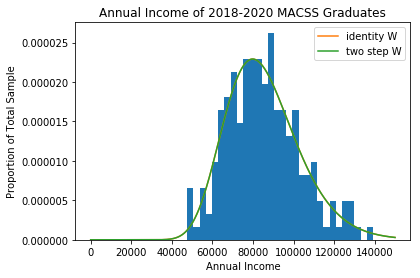

In [143]:
num_bins = 30
count,bins,ignored = plt.hist(income["income"], num_bins,normed=True)
pts=np.linspace(0,150000,100000)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM, sig_GMM,0,150000),label="identity W")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM2, sig_GMM2,0,150000),label="two step W")
plt.legend()
plt.show()

In [144]:
mean_model2, std_model2 = model_moments(mu_GMM2, sig_GMM2, 0, 150000)
print( "mean of data:",mean_data,"standard deviation of data:",std_data)
print( "mean from model",mean_model2,"standard deviation from model:",std_model2)
print("the difference between mean of data and mean from model is:",abs(mean_data-mean_model2),"the difference between standard deviation of data and that from model is:",abs(std_data-std_model2))

mean of data: 85276.82360625808 standard deviation of data: 18037.692869371564
mean from model 85276.82405894266 standard deviation from model: 18037.692424757075
the difference between mean of data and mean from model is: 0.00045268457324709743 the difference between standard deviation of data and that from model is: 0.00044461448851507157


In [162]:
#d
def data_moments3(x):
    mom1_data = len(x[x<75000])/len(x)
    mom2_data = len(x[(x>=75000)&(x<=100000)])/len(x)
    mom3_data = len(x[x>100000])/len(x)
    
    return mom1_data, mom2_data,mom3_data

def model_moments3(mu, sigma, cut_lb=0.0, cut_ub=150000.0):
    xfx = lambda x: sts.lognorm.pdf(x, scale = np.exp(mu), s=sigma)
    (mom1_model, m_m_err) = intgr.quad(xfx, 0, 75000)
    (mom2_model, m_m_err)= intgr.quad(xfx, 75000, 100000)
    (mom3_model, m_m_err) = intgr.quad(xfx, 100000, np.inf)    
    return mom1_model,mom2_model,mom3_model

def err_vec3(x, mu, sigma, cut_lb, cut_ub, simple):
  
    mom1_data, mom2_data,mom3_data = data_moments3(x)
    mom_data = np.array([[mom1_data], [mom2_data],[mom3_data]])
    mom1_model,mom2_model,mom3_model = model_moments3(mu, sigma, cut_lb, cut_ub)
    mom_model = np.array([[mom1_model],[mom2_model],[mom3_model]])
    
    if simple:
        err_vec = mom_model - mom_data
    else:
        err_vec = (mom_model - mom_data) / mom_data
    
    return err_vec

def crit3(params, *args):

    mu, sigma = params
    x, cut_lb, cut_ub, W = args
    err = err_vec3(x, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val



In [167]:
mu_init=11
sigma_init=0.5
para_init=(mu_init,sigma_init)
gmm_args=(income["income"],0.0,150000.0,np.eye(3))
results = opt.minimize(crit3,para_init,args=(gmm_args),bounds=((1e-10, None), (1e-10, None)))

In [168]:
mu_GMM3,sig_GMM3 = results.x
print("new mu_GMM:",mu_GMM3,"new sigma_GMM:",sig_GMM3)
para_gmm3=mu_GMM3,sig_GMM3
crit_val3=crit3(para_gmm3,income["income"],0,150000,np.eye(3))
print("value of criterion function:",crit_val3)

new mu_GMM: 11.335681325706043 new sigma_GMM: 0.21059845293921461
value of criterion function: [[4.55891775e-15]]


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


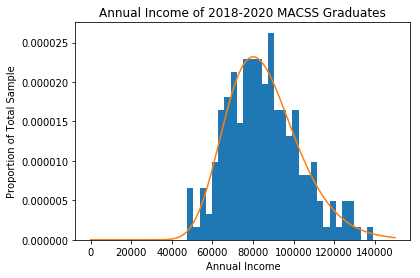

In [169]:
num_bins = 30
count,bins,ignored = plt.hist(income["income"], num_bins,normed=True)
pts=np.linspace(0,150000,100000)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM3, sig_GMM3,0,150000))

In [170]:
mom1_data, mom2_data,mom3_data = data_moments3(income["income"])
mom1_model,mom2_model,mom3_model = model_moments3(mu_GMM3,sig_GMM3,0,150000)
print( "1st moment of data:",mom1_data,"2nd moment of data:",mom2_data,"3rd moment of data:",mom3_data)
print( "1st moment from model:",mom1_model,"2nd moment from model:",mom2_model,"3rd moment from model:",mom3_model)
print("the difference between 1st moment of data and 1st moment from model is:",abs(mom1_data-mom1_model))
print("the difference between 2nd moment of data and 2nd moment from model is:",abs(mom2_data-mom2_model))
print("the difference between 3rd moment of data and 3rd moment from model is:",abs(mom3_data-mom3_model))

1st moment of data: 0.3 2nd moment of data: 0.5 3rd moment of data: 0.2
1st moment from model: 0.30000000579367986 2nd moment from model: 0.5000000068524717 3rd moment from model: 0.19999998735384858
the difference between 1st moment of data and 1st moment from model is: 5.793679869192658e-09
the difference between 2nd moment of data and 2nd moment from model is: 6.852471701179752e-09
the difference between 3rd moment of data and 3rd moment from model is: 1.2646151431594532e-08


In [171]:
#e
def Err_mat3(pts, mu, sigma, cut_lb, cut_ub, R=3,simple=False):
    N = len(pts)
    Err_mat = np.zeros((R, N))
    mom1_model,mom2_model,mom3_model = model_moments3(mu, sigma, cut_lb, cut_ub)
    if simple:
        Err_mat[0, :] = (pts<75000) - mom1_model
        Err_mat[1, :] = ((pts>=75000)&(pts<=100000)) - mom2_model
        Err_mat[2, :] = (pts>100000) - mom3_model
    else:
        Err_mat[0, :] = ((pts<75000) - mom1_model)/mom1_model
        Err_mat[1, :] = (((pts>=75000)&(pts<=100000)) - mom2_model)/mom2_model
        Err_mat[2, :] = ((pts>100000) - mom3_model)/mom3_model
    return Err_mat

In [172]:

err_mat = Err_mat3(income["income"], mu_GMM3, sig_GMM3, 0, 150000,R=3,simple = False)
VCV2 = (1 / pts.shape[0]) * (err_mat @ err_mat.T)#omega=1/N * E(x|theta_1gmm)*E(x|theta_1gmm)^T 
print("Omega_2: ",VCV2)

W_hat2 = lin.inv(VCV2)
print("W_hat2: ",W_hat2)

Omega_2:  [[ 0.00466667 -0.002      -0.002     ]
 [-0.002       0.002      -0.002     ]
 [-0.002      -0.002       0.008     ]]
W_hat2:  [[5.69075537e+16 9.48459223e+16 3.79383660e+16]
 [9.48459223e+16 1.58076536e+17 6.32306096e+16]
 [3.79383660e+16 6.32306096e+16 2.52922419e+16]]


In [173]:
para_init=(mu_GMM3,sig_GMM3)
gmm3_args=(arr_income,0,150000,W_hat2)
results3 = opt.minimize(crit3,para_init,args=(gmm3_args),bounds=((1e-10, None), (1e-10, None)))
mu_GMM32,sig_GMM32=results3.x


In [174]:
print("new 2 step mu_GMM:",mu_GMM32,"new 2 step sigma_GMM2:",sig_GMM32)
para_gmm32=mu_GMM32,sig_GMM32
crit_val32=crit3(para_gmm32,arr_income,0,150000,W_hat2)
print("value of criterion function:",crit_val32)

new 2 step mu_GMM: 11.335681325706387 new 2 step sigma_GMM2: 0.2105984529394583
value of criterion function: [[1.18141098e-12]]


In [175]:
mom1_model,mom2_model,mom3_model = model_moments3(mu_GMM32, sig_GMM32, 0, 150000)
mom1_data, mom2_data,mom3_data = data_moments3(arr_income)
print("three moments of data:",mom1_data, mom2_data,mom3_data)
print("three moments from model:",mom1_model,mom2_model,mom3_model)

three moments of data: 0.3 0.5 0.2
three moments from model: 0.3000000057933219 0.5000000068520989 0.19999998735457922


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in multiply


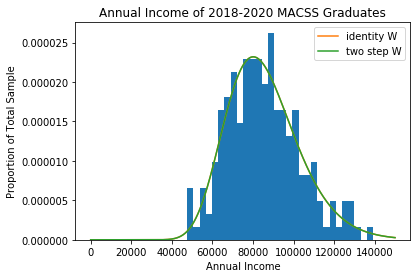

In [176]:
num_bins = 30
count,bins,ignored = plt.hist(arr_income, num_bins,normed=True)
pts=np.linspace(0,150000,100000)
plt.title("Annual Income of 2018-2020 MACSS Graduates")
plt.xlabel("Annual Income")
plt.ylabel("Proportion of Total Sample")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM3, sig_GMM3,0,150000),label="identity W")
plt.plot(pts,trunc_lognorm_pdf(pts, mu_GMM32, sig_GMM32,0,150000),label="two step W")
plt.legend()
plt.show()

In [177]:
#f
print("the value of criterion function from part(b) is :",crit_val)
print("the value of criterion function from part(c) is :",crit_val2)
print("the value of criterion function from part(d) is :",crit_val3)
print("the value of criterion function from part(e) is :",crit_val32)

the value of criterion function from part(b) is : [0.00182129]
the value of criterion function from part(c) is : [[2.63596202e-15]]
the value of criterion function from part(d) is : [[4.55891775e-15]]
the value of criterion function from part(e) is : [[1.18141098e-12]]


Therefore, the estimations of part (b) fits the data best, for its value of criterion function is smallest.

**2. Linear regression and GMM**

In [178]:
sick=pd.read_csv("sick.txt")


In [179]:
#def s_model_moments(b0,b1,b2,b3):
   # model_moments=b0+b1*sick["age"]+b2*sick["children"]+b3*sick["avgtemp_winter"]
 #   return model_moments

In [180]:
def err_vec(b0, b1, b2, b3):
    err_vec = b0+b1*sick["age"]+b2*sick["children"]+b3*sick["avgtemp_winter"]-sick["sick"]
    return err_vec


def crit(params, *args):

    b0,b1,b2,b3 = params
    W = args
    err = np.array(err_vec(b0, b1, b2, b3))
    crit_val = err.T @ W @ err
    
    return crit_val

In [181]:
para_init=(1,0.1,0.1,0.1)

results = opt.minimize(crit,para_init,args=(np.eye(200)))
print(results)

      fun: 0.0018212897096010381
 hess_inv: array([[ 0.05280017,  0.00043398, -0.00904355, -0.00119908],
       [ 0.00043398,  0.0002267 , -0.00202797, -0.00014215],
       [-0.00904355, -0.00202797,  0.0208239 ,  0.00128675],
       [-0.00119908, -0.00014215,  0.00128675,  0.0001096 ]])
      jac: array([6.04433444e-05, 5.27274930e-03, 1.35598631e-04, 5.54506869e-03])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 372
      nit: 4
     njev: 60
   status: 2
  success: False
        x: array([ 0.25164399,  0.01293351,  0.40050077, -0.00999171])


In [182]:
b0,b1,b2,b3=results.x
params=results.x
crit_val=crit(params,np.eye(200))
print("estimates for b0,b1,b2,b3 are:",b0,b1,b2,b3)
print("the value of criterion function is :",crit_val)

estimates for b0,b1,b2,b3 are: 0.25164398804681853 0.012933508409111307 0.4005007675654694 -0.009991712794546425
the value of criterion function is : [0.00182129]
